In [1]:
# This notebook is derived from Qiskit and includes modifications by qBraid.
#
# (C) Copyright IBM 2020.
# (C) Copyright qBraid 2023.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

# qBraid-SDK IBM Batch Jobs Demo: Grover's Algorithm


In [2]:
import qbraid

qbraid.__version__

'0.4.5'

## Creating the Circuits

In [3]:
import numpy as np

from qiskit import QuantumCircuit

The code for this circuit was taken from IBMs [Qiskit Textbook](https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm). Grover's algorithm let's us find a marked item in a box in √N steps as opposed to N steps classicaly. In this case we'll run Grover's algorithm for various numbers of steps to observe how the performance varies. This will allow us to test qBraid's [run_batch](https://github.com/qBraid/qBraid/blob/6e6cecc3ec4b7bac973f557606778d2cd07b8307/qbraid/devices/ibm/device.py#L111) functionality.

In [4]:
n = 3
marked_entry = np.random.randint(0, 2**n - 1)
print("marked entry: ", marked_entry)

marked entry:  1


In [5]:
Vf = QuantumCircuit(n, n)

Uw = []
for i in range(2**n):
    if i == marked_entry:
        Uw.append(-1)
    else:
        Uw.append(1)
Vf.diagonal(Uw, [0, 1, 2])


# Diffuser from the Qiskit Textbook
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits - 1)
    qc.mct(list(range(nqubits - 1)), nqubits - 1)  # multi-controlled-toffoli
    qc.h(nqubits - 1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s


W = QuantumCircuit(n, n)
W.append(diffuser(n), range(n))
VW = Vf.compose(W)

In [6]:
# create list of circuits to run
n_steps = 3
grover_init = QuantumCircuit(VW.num_qubits, VW.num_clbits)
grover_init.h(range(n))  # add the Hadamards
circuits = [grover_init]  # circuits[j] will have (VW)**j:
for _ in range(n_steps):
    circuits.append(circuits[-1].compose(VW))
for grover in circuits:
    grover.measure(range(n), range(n))  # add measurements

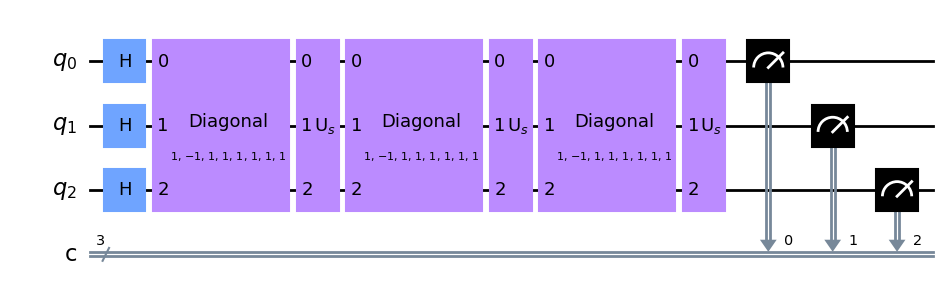

In [7]:
from qbraid.interface import circuit_drawer

circuit_drawer(circuits[3], "mpl")

Now that we've created our Grover circuit for n = 0, 1, 2, and 3, we can simply pass the `circuits` array

# Running the Circuits

Check which devices are online:

In [8]:
from qbraid import get_devices

get_devices(filters={"vendor": "IBM"})

Provider,Name,qBraid ID,Status
IBM,Belem,ibm_q_belem,●
IBM,Ext. stabilizer simulator,ibm_q_simulator_extended_stabilizer,●
IBM,Jakarta,ibm_q_jakarta,●
IBM,Lagos,ibm_q_lagos,●
IBM,Lima,ibm_q_lima,○
IBM,MPS simulator,ibm_q_simulator_mps,●
IBM,Manila,ibm_q_manila,●
IBM,Nairobi,ibm_q_nairobi,○
IBM,Oslo,ibm_q_oslo,○
IBM,Perth,ibm_q_perth,●


Now let's load in our IBM account. Note that you'll have to have IBM credentials to run this notebook. You can follow the instructions [here](https://github.com/Qiskit/qiskit-ibm-provider#provider-setup) to set them up.

In [9]:
# from qiskit_ibm_provider import IBMProvider

# # Replace with your IBM Credentials
# IBMProvider.save_account(token='MY_API_TOKEN')

In this tutorial we'll use IBM's Lima computer, since we see that it's online. Now we can use qBraid's [device wrapper](https://docs.qbraid.com/en/latest/sdk/devices.html#device-wrapper) to run this job. The device wrapper adds a layer of abstraction, allowing us to run more types of circuits on more devices, and in this case letting us use the `run_batch` method. 

Batch experiments combine individual experiments on any subset of qubits into a single composite experiment which appends all the circuits from each component experiment into a single batch of circuits to be executed as one experiment job. This is useful because it allows us to run multiple circuits in parallel. It is especially useful for situations like this, where we want to run many similar circuits and collectively analyze their results

In [10]:
from qbraid import device_wrapper
from qbraid.devices.ibm import ibm_least_busy_qpu

least_busy = ibm_least_busy_qpu()

device = device_wrapper(least_busy)

print(device.name)

Quito


In [11]:
job = device.run_batch(circuits, shots=1000)

In [12]:
job.status()

<JobStatus.QUEUED: 'job is queued'>

In [13]:
from qbraid import job_wrapper

job = job_wrapper("ibm_q_quito-ryanjh88-qjob-tpiweqahzl7g43udq1j9")

job.status()

<JobStatus.COMPLETED: 'job has successfully run'>

In [14]:
batch_result = job.result()
batch_counts = batch_result.measurement_counts()

for count in batch_counts:
    print(count)

{'000': 157, '001': 127, '010': 122, '011': 114, '100': 141, '101': 122, '110': 105, '111': 112}
{'000': 95, '001': 582, '010': 112, '011': 77, '100': 31, '101': 57, '110': 25, '111': 21}
{'000': 145, '001': 470, '010': 60, '011': 103, '100': 53, '101': 71, '110': 34, '111': 64}
{'000': 161, '001': 221, '010': 118, '011': 95, '100': 119, '101': 113, '110': 98, '111': 75}


We see that our results line up roughly with the theoretical prediction in the xtebook. With 0 grover steps, the probability is basically evenly distributed. At one step, we see it is roughly 80% correct, as we expect. The probability then peaks at 2 steps and dips again at 3 steps.